# SOTA Model: LSTM

### Import Libraries

##### Suppress Warnings

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support

from keras.utils import to_categorical

import matplotlib.pyplot as plt

## Data

#### Read Whole Data

In [4]:
dataset = pd.read_csv('Dataset/final_dataset_volume_1.csv')

features = dataset.iloc[:, :-1]
labels = dataset.iloc[:,-1]

#### Prepare/Save Train+Test Data

In [5]:
n_classes = 9
categorical_labels = to_categorical(labels, num_classes=n_classes, dtype ="int32")

# Reshape the input data into a 3D tensor to use as input for LSTM
n_samples = features.shape[0]
n_timesteps = 15  # flattened 15 rows to one feature
n_features = 75  # 3 sensor readings for each of 25 joints
X = features.values.reshape(n_samples, n_timesteps, n_features)

# split the data into training and testing sets
dr = 'TrainTestData/'

if all(os.path.exists(dr + path) for path in ['X_train_data.npy', 'X_test_data.npy', 'y_train_data.npy', 'y_test_data.npy']):
    print('Loading existing train and test data')
    X_train = np.load(dr + 'X_train_data.npy')
    X_test  = np.load(dr + 'X_test_data.npy')
    y_train = np.load(dr + 'y_train_data.npy')
    y_test  = np.load(dr + 'y_test_data.npy')
else:
    print('Creating new train and test data')
    X_train, X_test, y_train, y_test = train_test_split(X, categorical_labels, test_size=0.2)
    np.save(dr + 'X_train_data.npy', X_train)
    np.save(dr + 'X_test_data.npy' , X_test)
    np.save(dr + 'y_train_data.npy', y_train)
    np.save(dr + 'y_test_data.npy' , y_test)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, sep='\n')

Loading existing train and test data
(26150, 15, 75)
(6538, 15, 75)
(26150, 9)
(6538, 9)


## Defining LSTM Model

### Load Model (if existent)

In [7]:
sota_model = None
if os.path.exists('cs3244_project2_lstm_model.h5'):
    # If saved model exists, load model
    print('Loading saved model weights')
    sota_model = tf.keras.models.load_model('cs3244_project2_lstm_model.h5')
    print("Skip to section 'Model Training' or 'Model Prediction'")
else:
    print('No saved model weights found')
    print('Create and train a new LSTM model')

No saved model weights found
Create and train a new LSTM model


### Hyperparameter Tuning (Grid Search)

In [15]:
def tune_LSTM_model(units, dropout_rate, _X_train, _y_train, _X_val, _y_val, verbose=1):
    # Unpack units per layer
    LSTM_units, dense_units1, dense_units2 = units
    
    model = Sequential()
    # Input layer: LSTM
    model.add(LSTM(
        units=LSTM_units, input_shape=(n_timesteps, n_features),
        dropout=dropout_rate, recurrent_dropout=dropout_rate
    ))
    # Two hidden recurrent layers
    model.add(Dense(units=dense_units1, name='hidden-1', activation='relu'))
    model.add(Dense(units=dense_units2, name='hidden-2', activation='relu'))
    # Output layer
    model.add(Dense(units=n_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(_X_train, _y_train, epochs=10, batch_size=128, verbose=verbose)
    
    score = model.evaluate(_X_val, _y_val, verbose=0)
    return score

In [16]:
def grid_search(loss_grid, acc_grid, units, dropout_rate=[0.2, 0.5], num_folds=5, verbose=1):
    for dropout_rate in [0.2, 0.5]:
        print(f'Testing hyperparameters [{units=}] and [{dropout_rate=}]')
        
        sum_loss, sum_acc = 0, 0
        skf = StratifiedKFold(n_splits=num_folds)
        folds = skf.split(X_train, np.argmax(y_train, axis=1))

        for i, (train_idx, val_idx) in enumerate(folds):
            _X_train, _X_val = X_train[train_idx], X_train[val_idx]
            _y_train, _y_val = y_train[train_idx], y_train[val_idx]

            loss, acc = tune_LSTM_model(units, dropout_rate, _X_train, _y_train, _X_val, _y_val, verbose)
            sum_loss += loss
            sum_acc += acc
            
            print(f'Fold {i + 1} | Loss = {loss} | Accuracy = {acc}')
            print('-----------------------------------------------------------------')

        mean_loss = sum_loss / num_folds
        mean_acc = sum_acc / num_folds
        
        loss_grid[(units, dropout_rate)] = mean_loss
        acc_grid[(units, dropout_rate)] = mean_acc
        
        print(f'Hyperparameters [{(units, dropout_rate)=}] | Mean Loss = {mean_loss} | Mean Accuracy = {mean_acc}\n')

In [10]:
loss_grid = {}
acc_grid = {}

In [17]:
lstm_units = [32, 64, 128]
dense_units = [32, 64, 128]
for i, j in np.ndindex(3, 3):
    u1, u2 = lstm_units[i], dense_units[j]
    grid_search(loss_grid, acc_grid, (u1, u2, u2), verbose=0)
    grid_search(loss_grid, acc_grid, (u1, u2, u2 // 2), verbose=0)

Testing hyperparameters [units=(32, 32, 32)] and [dropout_rate=0.2]
Fold 1 | Loss = 0.2805596888065338 | Accuracy = 0.8977055549621582
-----------------------------------------------------------------
Fold 2 | Loss = 0.34752601385116577 | Accuracy = 0.8732313513755798
-----------------------------------------------------------------
Fold 3 | Loss = 0.2585730254650116 | Accuracy = 0.9059273600578308
-----------------------------------------------------------------
Fold 4 | Loss = 0.3226015567779541 | Accuracy = 0.8747609853744507
-----------------------------------------------------------------
Fold 5 | Loss = 0.3174642026424408 | Accuracy = 0.8785851001739502
-----------------------------------------------------------------
Hyperparameters [(units, dropout_rate)=((32, 32, 32), 0.2)] | Mean Loss = 0.3053448975086212 | Mean Accuracy = 0.8860420703887939

Testing hyperparameters [units=(32, 32, 32)] and [dropout_rate=0.5]
Fold 1 | Loss = 0.4183224141597748 | Accuracy = 0.8393881320953369


In [19]:
units = [(256, 128), (256, 256), (512, 256)]
for u1, u2 in units:
    grid_search(loss_grid, acc_grid, (u1, u2, u2), verbose=0)
    grid_search(loss_grid, acc_grid, (u1, u2, u2 // 2), verbose=0)

Testing hyperparameters [units=(256, 128, 128)] and [dropout_rate=0.2]
Fold 1 | Loss = 0.12387274950742722 | Accuracy = 0.9535372853279114
-----------------------------------------------------------------
Fold 2 | Loss = 0.15567421913146973 | Accuracy = 0.9399617314338684
-----------------------------------------------------------------
Fold 3 | Loss = 0.1428241729736328 | Accuracy = 0.9449330568313599
-----------------------------------------------------------------
Fold 4 | Loss = 0.13941971957683563 | Accuracy = 0.9491395950317383
-----------------------------------------------------------------
Fold 5 | Loss = 0.160378098487854 | Accuracy = 0.9390057325363159
-----------------------------------------------------------------
Hyperparameters [(units, dropout_rate)=((256, 128, 128), 0.2)] | Mean Loss = 0.14443379193544387 | Mean Accuracy = 0.9453154802322388

Testing hyperparameters [units=(256, 128, 128)] and [dropout_rate=0.5]
Fold 1 | Loss = 0.21196013689041138 | Accuracy = 0.91128

In [9]:
grid_search(loss_grid, acc_grid, (512, 512, 256))

Testing hyperparameters [units=(512, 512, 256)] and [dropout_rate=0.2]
Epoch 1/10
164/164 [==============================] - 19s 110ms/step - loss: 0.9618 - accuracy: 0.6284
Epoch 2/10
164/164 [==============================] - 19s 114ms/step - loss: 0.5316 - accuracy: 0.7952
Epoch 3/10
164/164 [==============================] - 19s 116ms/step - loss: 0.4115 - accuracy: 0.8430
Epoch 4/10
164/164 [==============================] - 19s 118ms/step - loss: 0.3498 - accuracy: 0.8668
Epoch 5/10
164/164 [==============================] - 20s 123ms/step - loss: 0.3200 - accuracy: 0.8764
Epoch 6/10
164/164 [==============================] - 20s 122ms/step - loss: 0.2730 - accuracy: 0.8976
Epoch 7/10
164/164 [==============================] - 20s 123ms/step - loss: 0.2676 - accuracy: 0.9000
Epoch 8/10
164/164 [==============================] - 20s 123ms/step - loss: 0.2395 - accuracy: 0.9077
Epoch 9/10
164/164 [==============================] - 20s 124ms/step - loss: 0.2253 - accuracy: 0.9163
Ep

In [11]:
grid_search(loss_grid, acc_grid, (1024, 512, 512))

Testing hyperparameters [units=(1024, 512, 512)] and [dropout_rate=0.2]
Epoch 1/10
164/164 [==============================] - 140s 853ms/step - loss: 1.1422 - accuracy: 0.5574
Epoch 2/10
164/164 [==============================] - 135s 821ms/step - loss: 0.5256 - accuracy: 0.8017
Epoch 3/10
164/164 [==============================] - 131s 796ms/step - loss: 0.4020 - accuracy: 0.8477
Epoch 4/10
164/164 [==============================] - 130s 791ms/step - loss: 0.3458 - accuracy: 0.8666
Epoch 5/10
164/164 [==============================] - 128s 780ms/step - loss: 0.3167 - accuracy: 0.8777
Epoch 6/10
164/164 [==============================] - 126s 771ms/step - loss: 0.3004 - accuracy: 0.8859
Epoch 7/10
164/164 [==============================] - 129s 785ms/step - loss: 0.2596 - accuracy: 0.9009
Epoch 8/10
164/164 [==============================] - 129s 788ms/step - loss: 0.2449 - accuracy: 0.9085
Epoch 9/10
164/164 [==============================] - 127s 774ms/step - loss: 0.2220 - accuracy:

In [12]:
grid_search(loss_grid, acc_grid, (1024, 1024, 512))

Testing hyperparameters [units=(1024, 1024, 512)] and [dropout_rate=0.2]
Epoch 1/10
164/164 [==============================] - 126s 766ms/step - loss: 1.0082 - accuracy: 0.6149
Epoch 2/10
164/164 [==============================] - 126s 767ms/step - loss: 0.5191 - accuracy: 0.8006
Epoch 3/10
164/164 [==============================] - 127s 776ms/step - loss: 0.4125 - accuracy: 0.8426
Epoch 4/10
164/164 [==============================] - 127s 773ms/step - loss: 0.3578 - accuracy: 0.8631
Epoch 5/10
164/164 [==============================] - 129s 784ms/step - loss: 0.3075 - accuracy: 0.8805
Epoch 6/10
164/164 [==============================] - 128s 778ms/step - loss: 0.2936 - accuracy: 0.8881
Epoch 7/10
164/164 [==============================] - 126s 770ms/step - loss: 0.2512 - accuracy: 0.9040
Epoch 8/10
164/164 [==============================] - 126s 770ms/step - loss: 0.2442 - accuracy: 0.9089
Epoch 9/10
164/164 [==============================] - 127s 777ms/step - loss: 0.2092 - accuracy

## Analyze Results

### Table of Accuracy/Loss of all Hyperparameters 

In [28]:
lstm, dense1, dense2, dropout = [], [], [], []
for (u1, u2, u3), dr in loss_grid.keys():
    lstm.append(u1)
    dense1.append(u2)
    dense2.append(u3)
    dropout.append(dr)

table = {
    'Hyperparameter': list(loss_grid.keys()),
    'LSTM Units': lstm,
    'Dense1 Units': dense1,
    'Dense2 Units': dense2,
    'Dropout Rate': dropout,
    'Loss': list(loss_grid.values()),
    'Accuracy': list(acc_grid.values())
}

df = pd.DataFrame(table)

# Save for later use
df.to_csv('Hyperparameter/loss_acc_scores.csv')

# Print table
df

,Hyperparameter,LSTM Units,Dense1 Units,Dense2 Units,Dropout Rate,Loss,Accuracy
0,"((32, 32, 32), 0.2)",32,32,32,0.2,0.305345,0.886042
1,"((32, 32, 32), 0.5)",32,32,32,0.5,0.408373,0.842639
2,"((32, 32, 16), 0.2)",32,32,16,0.2,0.300359,0.891243
3,"((32, 32, 16), 0.5)",32,32,16,0.5,0.414303,0.843098
4,"((32, 64, 64), 0.2)",32,64,64,0.2,0.265929,0.901415
5,"((32, 64, 64), 0.5)",32,64,64,0.5,0.382988,0.851243
6,"((32, 64, 32), 0.2)",32,64,32,0.2,0.276148,0.896252
7,"((32, 64, 32), 0.5)",32,64,32,0.5,0.390918,0.849522
8,"((32, 128, 128), 0.2)",32,128,128,0.2,0.244073,0.905163
9,"((32, 128, 128), 0.5)",32,128,128,0.5,0.364035,0.855985


### Plot of Accuracy/Loss of all Hyperparameters

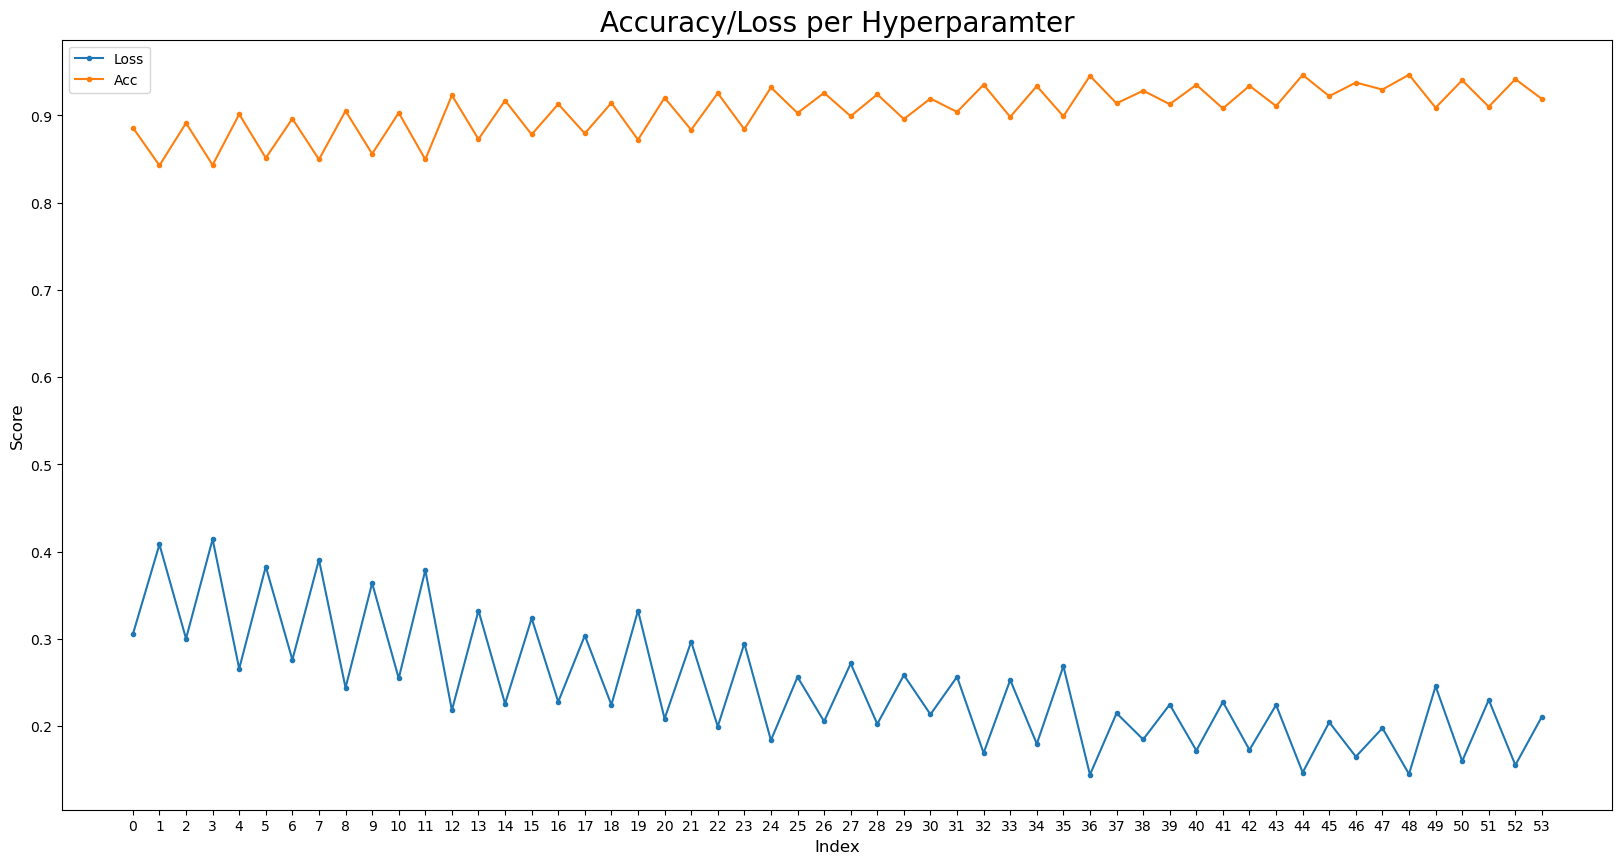

In [58]:
# Show plot of all hyperparameters and their loss, acc scores
graph = {
    'Loss': loss_grid.values(),
    'Acc': acc_grid.values()
}

plt.figure(figsize=(20,10))
for k, v in graph.items():
    plt.plot(range(54), v, '.-', label=k)
    
plt.title('Accuracy/Loss per Hyperparamter', fontsize=20)
plt.xticks(range(54), range(54))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.show()

### Plot of Accuracy/Loss of Hyperparameters with Dropout Rate = 0.2

In the above graph, odd indices represent hyperparameters with `dropout_rate=0.5`.
Because we can see a drop in acc and an increase in loss for `dropout_rate=0.5`, we plotted hyperparameters with `dropout_rate=0.2` separately.

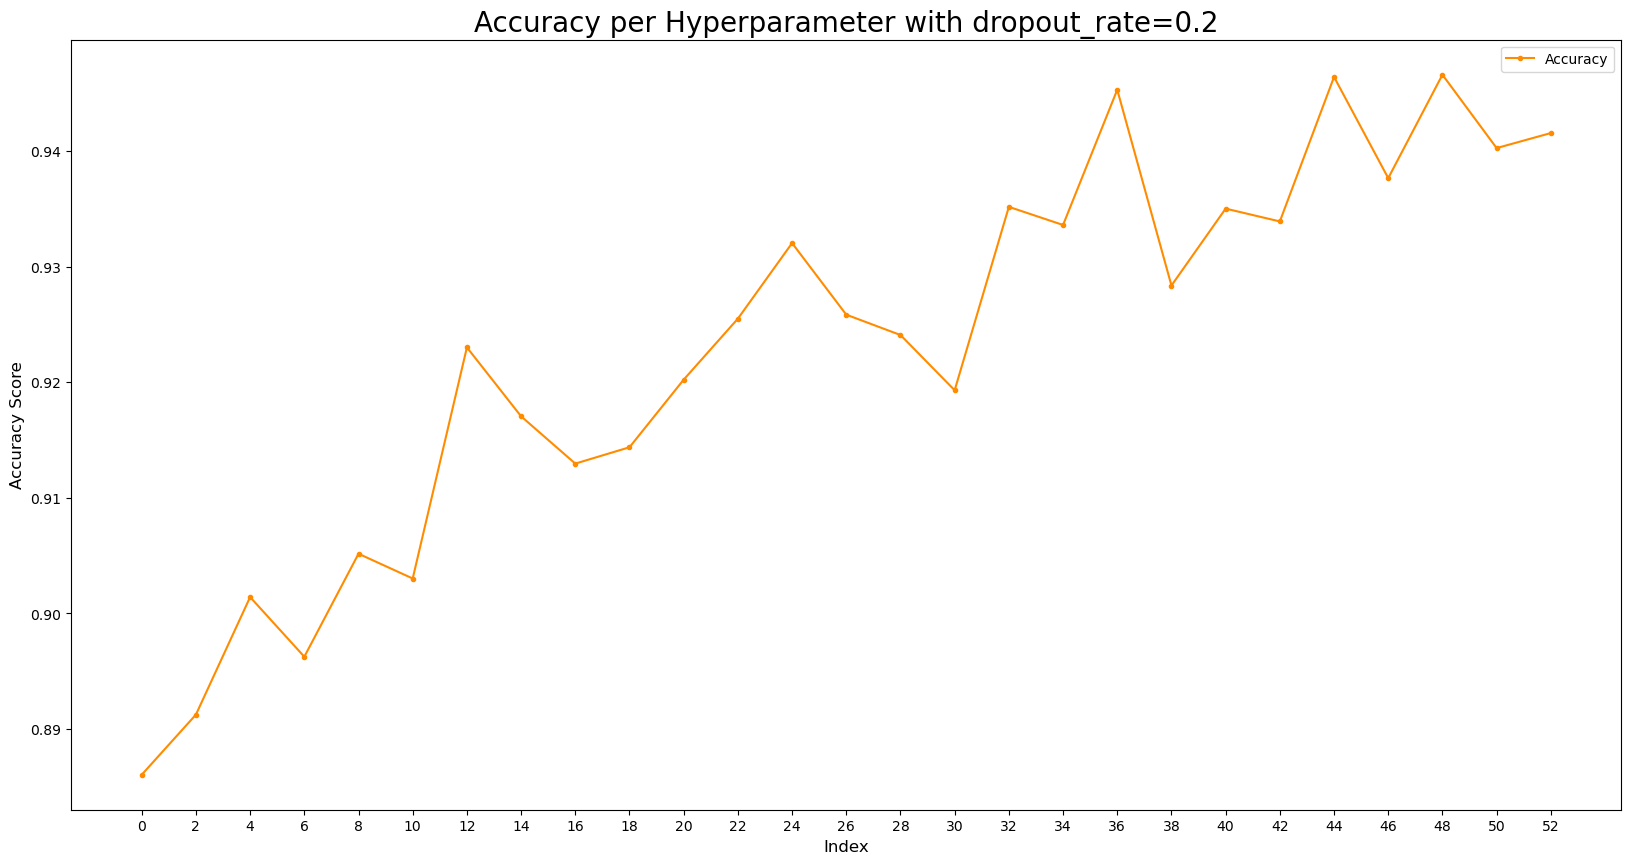

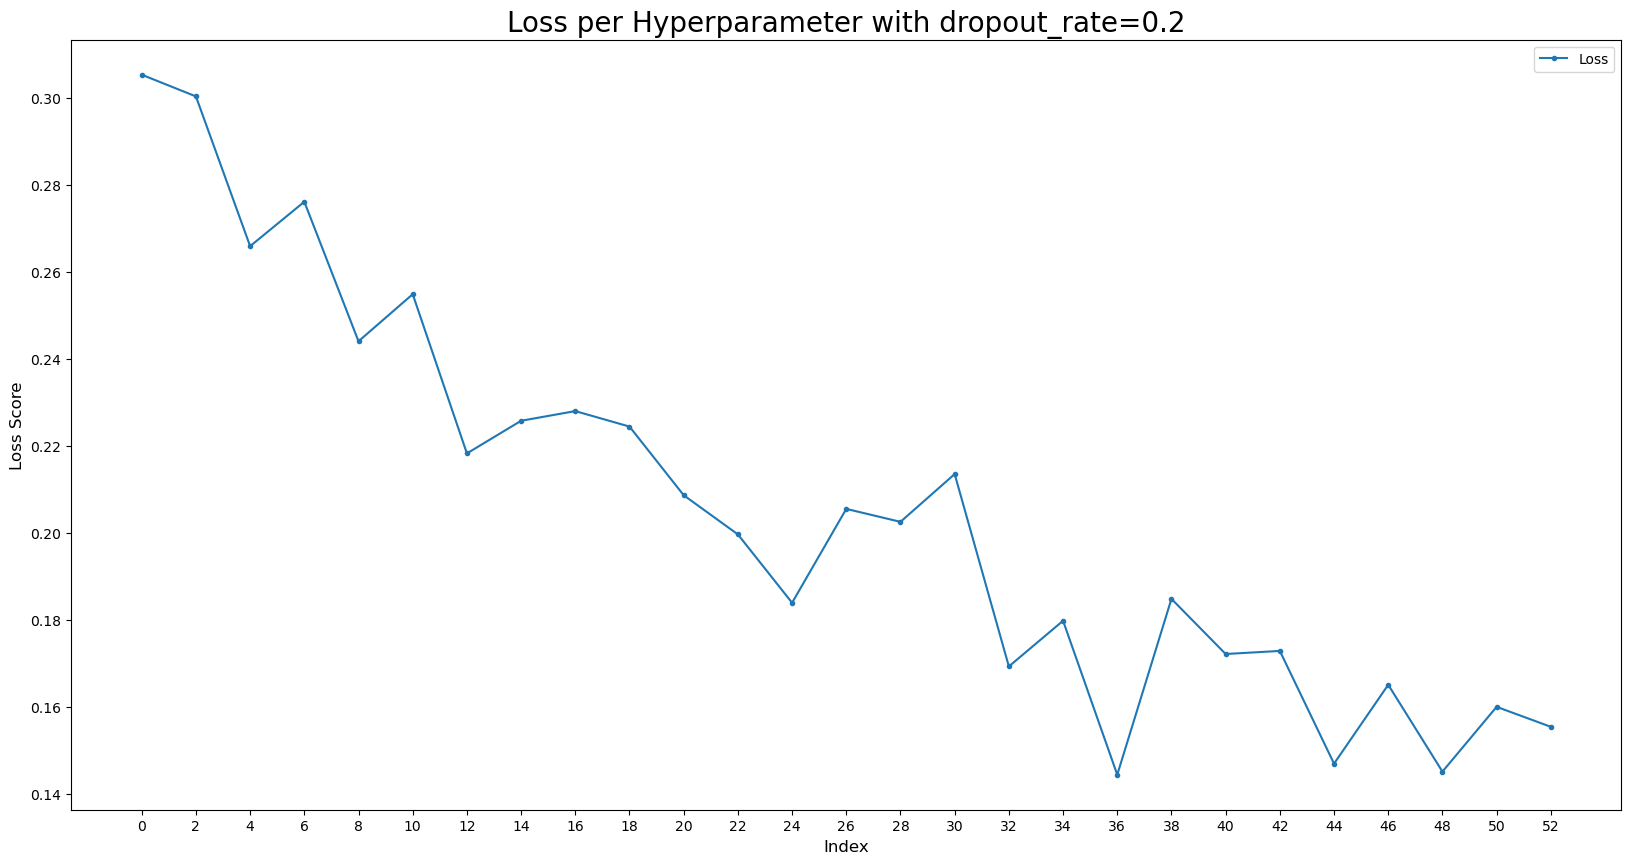

In [59]:
# Show separate plots for hyperparameters with dropout_rate=0.2
x_axis = [2 * n for n in range(27)]

plt.figure(figsize=(20, 10))
plt.plot(range(27), [v for k, v in acc_grid.items() if k[1] == 0.2], '.-', color='darkorange', label='Accuracy')
plt.title('Accuracy per Hyperparameter with dropout_rate=0.2', fontsize=20)
plt.xticks(range(27), x_axis)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.legend()
plt.show()

plt.figure(figsize=(20, 10))
plt.plot(range(27), [v for k, v in loss_grid.items() if k[1] == 0.2], '.-', label='Loss')
plt.title('Loss per Hyperparameter with dropout_rate=0.2', fontsize=20)
plt.xticks(range(27), x_axis)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Loss Score', fontsize=12)
plt.legend()
plt.show()

We can see peaks in accuracy scores for parameters with indices 36, 44, and 48. So we printed out the values to see the exact values.

In [48]:
df.iloc[[36, 44, 48], :]

,Hyperparameter,LSTM Units,Dense1 Units,Dense2 Units,Dropout Rate,Loss,Accuracy
36,"((256, 128, 128), 0.2)",256,128,128,0.2,0.144434,0.945315
44,"((512, 256, 256), 0.2)",512,256,256,0.2,0.146976,0.946424
48,"((512, 512, 256), 0.2)",512,512,256,0.2,0.145146,0.946616


In [60]:
df.sort_values('Accuracy', ascending=False).head(1)

,Hyperparameter,LSTM Units,Dense1 Units,Dense2 Units,Dropout Rate,Loss,Accuracy
48,"((512, 512, 256), 0.2)",512,512,256,0.2,0.145146,0.946616


Therefore, `lstm_units=512`, `dense1_units=512`, `dense2_units=256`, and `dropout_rate=recurrent_dropout=0.2` were chosen as hyperparameters of our LSTM model.